In [14]:
from __future__ import print_function
%matplotlib inline
from matplotlib.pylab import plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')
import numpy as np
import nilmtk
from nilmtk.utils import print_dict
from nilmtk import DataSet
from neuralnilm.data.loadactivations import load_nilmtk_activations
from neuralnilm.data.syntheticaggregatesource import SyntheticAggregateSource
from neuralnilm.data.realaggregatesource import RealAggregateSource
from neuralnilm.data.stridesource import StrideSource
from neuralnilm.data.datapipeline import DataPipeline
from neuralnilm.data.processing import DivideBy, IndependentlyCenter

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D
from keras.optimizers import SGD
import time


# create dictionary with train, unseen_house, unseen_appliance
def select_windows(train_buildings, unseen_buildings):
    windows = {fold: {} for fold in DATA_FOLD_NAMES}

    def copy_window(fold, i):
        windows[fold][i] = WINDOWS[fold][i]

    for i in train_buildings:
        copy_window('train', i)
        copy_window('unseen_activations_of_seen_appliances', i)
    for i in unseen_buildings:
        copy_window('unseen_appliances', i)
    return windows


def filter_activations(windows, activations):
    new_activations = {
        fold: {appliance: {} for appliance in APPLIANCES}
        for fold in DATA_FOLD_NAMES}
    for fold, appliances in activations.iteritems():
        for appliance, buildings in appliances.iteritems():
            required_building_ids = windows[fold].keys()
            required_building_names = [
                'UK-DALE_building_{}'.format(i) for i in required_building_ids]
            for building_name in required_building_names:
                try:
                    new_activations[fold][appliance][building_name] = (
                        activations[fold][appliance][building_name])
                except KeyError:
                    pass
    return activations    



NILMTK_FILENAME = './redd_data/redd.h5'
SAMPLE_PERIOD = 6
STRIDE = None
APPLIANCES = ['fridge']
WINDOWS = {
    'train': {
        1: ("2011-04-19", "2011-05-21"),
        2: ("2011-04-19", "2013-05-01"),
        3: ("2011-04-19", "2013-05-26"),
        6: ("2011-05-22", "2011-06-14"),
    },
    'unseen_activations_of_seen_appliances': {
        1: ("2011-04-19", None),
        2: ("2011-04-19", None),
        3: ("2011-04-19", None),
        6: ("2011-05-22", None),
    },
    'unseen_appliances': {
        5: ("2011-04-19", None)
    }
}

# get the dictionary of activations for each appliance
activations = load_nilmtk_activations(
    appliances=APPLIANCES,
    filename=NILMTK_FILENAME,
    sample_period=SAMPLE_PERIOD,
    windows=WINDOWS
)

# get pipeline for the fridge example
num_seq_per_batch = 64
target_appliance = 'fridge'
seq_length = 512
train_buildings = [1, 2, 3, 6]
unseen_buildings = [5]
DATA_FOLD_NAMES = (
    'train', 'unseen_appliances', 'unseen_activations_of_seen_appliances')

filtered_windows = select_windows(train_buildings, unseen_buildings)
filtered_activations = filter_activations(filtered_windows, activations)

synthetic_agg_source = SyntheticAggregateSource(
    activations=filtered_activations,
    target_appliance=target_appliance,
    seq_length=seq_length,
    sample_period=SAMPLE_PERIOD
)

real_agg_source = RealAggregateSource(
    activations=filtered_activations,
    target_appliance=target_appliance,
    seq_length=seq_length,
    filename=NILMTK_FILENAME,
    windows=filtered_windows,
    sample_period=SAMPLE_PERIOD
)


# ------------
# needed to rescale the input aggregated data
# rescaling is done using the a first batch of num_seq_per_batch sequences
sample = real_agg_source.get_batch(num_seq_per_batch=1024).next()
sample = sample.before_processing
input_std = sample.input.flatten().std()
target_std = sample.target.flatten().std()
# ------------



pipeline = DataPipeline(
    [synthetic_agg_source, real_agg_source],
    num_seq_per_batch=num_seq_per_batch,
    input_processing=[DivideBy(input_std), IndependentlyCenter()],
    target_processing=[DivideBy(target_std)]
)

/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/utils.py:383: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=9)
  data = data.resample(**resample_kwargs)


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     

/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/metergroup.py:901: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warn("As a quick implementation we only get Good Sections from"
/Users/thibaut/anaconda/envs/nilmtk-env/lib/python2.7/site-packages/pandas/tseries/base.py:155: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  val = getitem(key)
/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/utils.py:332: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  return resampled.index[0]
/Users/thibaut/Dropbox/Courses/am207/project_libraries/nilmtk/nilmtk/utils.py:383: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=5)
  


Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     

In [82]:
from keras.models import model_from_json
exp_num = 5
architecture = './tmpdata/convnet_architecture_exp' + str(exp_num) + '.json'
weights = './tmpdata/weights_exp' + str(exp_num) + '.h5'
model = model_from_json(open(architecture).read())
model.load_weights(weights)
model.compile(loss='mean_squared_error', optimizer='Adamax')

In [84]:
# number of sample
num_test_seq = 101
from neuralnilm.metrics import Metrics
score = Metrics(state_boundaries = [2.5])
Y_test = np.empty((64*num_test_seq,3))
Y_pred = np.empty((64*num_test_seq,3))
for i in range(num_test_seq):
    (x_test, y_test) = pipeline.train_generator(fold = 'unseen_appliances', source_id = 1).next()
    Y_test[64*i: 64*(i+1)] = y_test
    Y_pred[64*i: 64*(i+1)] = model.predict_on_batch(x_test)
results = score.compute_metrics(Y_pred, Y_test)
print
print(results)

{'regression': {'mean_squared_error': 0.005580795247560987, 'relative_error_in_total_energy': 0.00786775163249979, 'mean_absolute_error': 0.035334906412101054}, 'classification_2_state': {'f1_score': 0.23094688221709006, 'recall_score': 0.2958579881656805, 'accuracy_score': 0.9484839108910891, 'precision_score': 0.1893939393939394}}


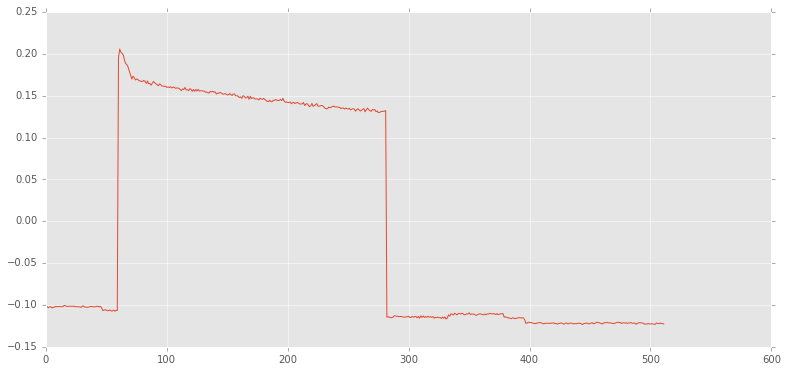

In [27]:
plt.plot(x_test[0,:])

In [32]:
from keras.layers import Input, Dense, Flatten, MaxPooling1D, Convolution1D
from keras.models import Model
# construct a new model to see the output after layers
# define the network architecture = Conv Net
input_seq = Input(shape = (seq_length, 1))
conv1_layer =  Convolution1D(nb_filter = 16, filter_length = 3, border_mode='valid',
                      init = 'normal', activation =  'relu')
conv1 = conv1_layer(input_seq)
conv1_maxpooling = MaxPooling1D(pool_length=2, stride=None, border_mode='valid')(conv1)
conv2 = Convolution1D(nb_filter = 32, filter_length = 3, border_mode='valid',
                      init = 'normal', activation =  'relu')(conv1_maxpooling)
conv2_maxpooling = MaxPooling1D(pool_length=2, stride=None, border_mode='valid')(conv2)
conv3 = Convolution1D(nb_filter = 64, filter_length = 3, border_mode='valid',
                      init = 'normal', activation =  'relu')(conv2_maxpooling)
model2 = Model(input = input_seq, output = conv3)
model2.compile(loss='mean_squared_error',
              optimizer='Adagrad')
x_input = x_test[0,:]
x_input= np.reshape(x_input, [1,512,1 ])
y_output= model2.predict(x_input)

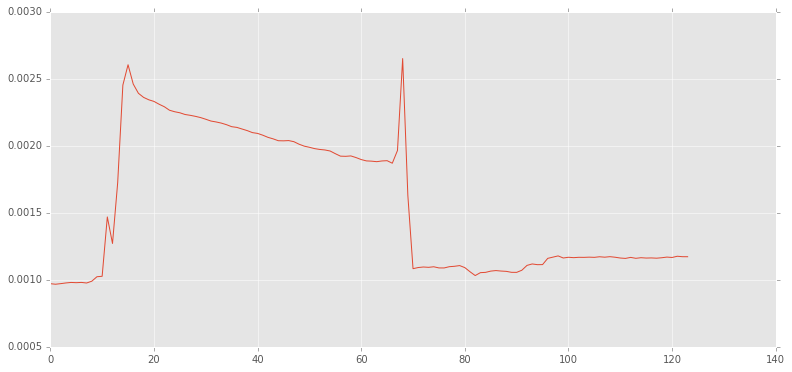

In [38]:
plt.plot(y_output[0,:,1])